In [360]:
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import LinearRegression 
from datetime import timedelta
from datetime import datetime
import io
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.stats import t
from outliers import smirnov_grubbs as grubbs
from scipy.optimize import curve_fit
from filterpy.kalman import KalmanFilter
import statistics
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
import math
from scipy.signal import convolve
from scipy.interpolate import interp1d

In [361]:
#Function for means, variance...
def st_values(l):
    size = len(l)
    if size >= 25:
        #Normal distribution
        fit = norm.fit(l)
        return fit[0],fit[1],'normal'
    if size < 25 and size >= 5:
        #T-STUDENT DISTR
        fit = t.fit(l)
        return fit[1],fit[2],'t'
    if size < 5:
        return average(l),np.std(l),np.s'n'
def append_dict(dic,distance,st):
    dic['distance'].append(distance)
    dic['mean'].append(st[0])
    dic['std'].append(np.abs(st[1]))
    dic['type'].append(st[2])

def distance_by_rssi(x,a,n):
    return np.power(10,-(x-a)/(10*n)) 

def rssy_by_distance(x,a,n):
    return 10*n*np.log(x)+a

def average(lst): 
    return sum(lst) / len(lst) 


In [362]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError

    if x.size < window_len:
        raise ValueError


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def conv_app(A, WSZ):
    K = np.ones(WSZ,dtype=int)
    L = WSZ-1
    return (np.convolve(np.convolve(A,K)>=WSZ,K)[L:-L]>0).astype(int)

In [363]:
#Import database
url = "http://btserver-lab10.polito.it/conn_info?csv=1"
s = requests.get(url).content
df1 = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=",")

#Set up the array 
df1.columns = ['ID1','ID2','MAC2','rssi','ismobile','timestamp','milliseconds']
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1.dtypes

ID1                     object
ID2                     object
MAC2                    object
rssi                   float64
ismobile                  bool
timestamp       datetime64[ns]
milliseconds             int64
dtype: object

In [364]:
error = []
values = []
lm = LinearRegression(n_jobs = 5)

In [407]:
#Load Json Data
with open('experiments.json') as json_data:
    experiments = json.load(json_data)
experiment = experiments[2]
start_dates = experiment['dates']
static_devices = experiment['static_devices']
non_static_devices = experiment['non_static_devices']
interval = experiment['interval']
distances = experiment['distances']


In [408]:
device1 = static_devices[0]
device2 = static_devices[1]
non_static = non_static_devices[0]

#Setting up the configuration
interval_s = timedelta(seconds = interval)
inverse_distances = distances.copy()
inverse_distances.reverse()

count_distances = len(distances)
#Define duration in seconds
duration = timedelta(seconds = interval * (count_distances-1))
values1 = []
values2 = []

lim = 30
lim_time = timedelta(seconds = 30)
for start_date in start_dates:
#     start_date = start_dates[0]
    start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    end = start + duration
    start = start 
    #How they see the static devices the non static devices with time
    #Matrix where they see the non_static device
    dfs =  df1[(df1.ID2 == non_static['id']) & (df1.timestamp >= (start- lim_time) ) & ((df1.timestamp) <=(end +lim_time) )]
    #Matrix that represent how each static device see the non static device
    d1 = dfs[dfs.ID1 == device1['id']]
    d2 = dfs[dfs.ID1 == device2['id']]   
    rssi1 = d1['rssi'].tolist()
    rssi2 = d2['rssi'].tolist()
    mfs1 =  d1['milliseconds'].sub(start.timestamp()*1000).tolist()
    mfs2 =  d2['milliseconds'].sub(start.timestamp()*1000).tolist()
    

In [409]:
np1 = np.array(values1)
np2 = np.array(values2)

#Preproces RSSI for device 1 (removing non-sense values)
mean1 = average(np1[:,1]) 
std1 = statistics.stdev(np1[:,1])
np_copy = []
for i in range(0,len(np1[:,1])):
    #print((mean1 -2 * std1))
    if (mean1 -2 * std1) < np1[i,1]:
        np_copy.append([np1[i,0],np1[i,1]])
np1 = np.array(np_copy)

#Preproces RSSI for device 2 (removing non-sense values)
mean2 = average(np2[:,1])
std2 = statistics.stdev(np2[:,1])
np_copy = []
for i in range(0,len(np2[:,1])):
    #print((mean1 -2 * std1))
    if (mean2 -2 * std2) < np2[i,1]:
        np_copy.append([np2[i,0],np2[i,1]])
np2 = np.array(np_copy)


In [410]:
# #Interval times values:
# v = []
# for i in range(0,len(np1[:,0])-1):
#     v.append(np1[i+1,0]-np1[i,0])
# mean_v = average(v)
# std_v = statistics.stdev(v)
# f = interp1d(np1[:,0],np1[:,1])v

# y = smooth(np1[:,1],window_len=5,window ="hanning")
# x = smooth(np1[:,0],window_len=5,window ="hanning")

# np1 = np.column_stack((x,y))



# y = smooth(np2[:,1],window_len=5,window ="hanning")
# x = smooth(np2[:,0],window_len=5,window ="hanning")
# np2 = np.column_stack((x,y))



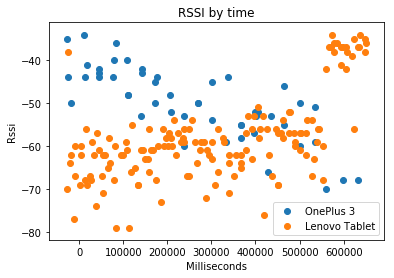

In [411]:

#How static devices see non static device depending of time
fig = plt.plot()
plt.title("RSSI by time")
plt.xlabel('Milliseconds')
plt.ylabel('Rssi')
p1 = plt.scatter(np1[:,0],np1[:,1])
p2 = plt.scatter(np2[:,0],np2[:,1])
#p3 = plt.plot(mfs1,test_model1)
#p3 = plt.plot(mfs2,test_model2)
p1.set_label(device1['name'])
p2.set_label(device2['name'])
plt.legend()
plt.show()

In [3]:
#data = pd.DataFrame({'milliseconds' : np1[:,0], 'rssi' : np1[:,1]})
#Linear regression fiting
X = np1[:,:-1]
X = np.array(X).reshape(-1,1)
y = np1[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)  
fit = lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)  
print(mean_squared_error(y_pred, y_test))
skor = lm.score(X_test,y_test)
print(lm.coef_)


fig = plt.plot()
plt.title("RSSI by time")
plt.xlabel('Milliseconds')
plt.ylabel('dbm')
p1 = plt.scatter(np1[:,0],np1[:,1],label='r2: '+str(round(skor,3)))
p2 = plt.plot(X_test,y_pred)
plt.legend(loc='best')
plt.show()


NameError: name 'np1' is not defined

In [4]:
#Transform to dataframe
dtnp1 = pd.DataFrame({'milliseconds':np1[:,0],'rssi':np1[:,1]})
dtnp2 = pd.DataFrame({'milliseconds':np2[:,0],'rssi':np2[:,1]})

list1_dist = []
list2_dist = []
revers_distances = distances.copy()
revers_distances.reverse()

#Convert times to distances
for i in range(0,len(distances)):

    start_point = i*1000*interval
    end_point = start_point + interval * 1000
    if i == 0:
        start_point = start_point - 1000*lim
    if i == len(distances)-1: 
        end_point = end_point + 1000*lim
    dt1_interval = np.array(dtnp1[(dtnp1.milliseconds >= start_point) & (dtnp1.milliseconds < end_point)].values.tolist())
    if(len(dt1_interval)>0):
        for index,rssi in enumerate(dt1_interval[:,1]):
            list1_dist.append(np.array([distances[i],rssi,dt1_interval[index,0]])) 
    #For device at 10 meters
    dt2_interval = np.array(dtnp2[(dtnp2.milliseconds >= start_point) & (dtnp2.milliseconds < end_point)].values.tolist())
    if(len(dt2_interval)>0):
        for index,rssi in enumerate(dt2_interval[:,1]):
            list2_dist.append(np.array([revers_distances[i],rssi,dt2_interval[index,0]]))
list1_dist=np.array(list1_dist)
list2_dist=np.array(list2_dist)

NameError: name 'pd' is not defined

In [414]:
#Calculate means, avergaes ...
dt1_distances = pd.DataFrame({'distance' : list1_dist[:,0], 'rssi' : list1_dist[:,1]})
dt2_distances = pd.DataFrame({'distance' : list2_dist[:,0], 'rssi' : list2_dist[:,1]})

dic1 = {'distance' : [], 'mean' : [], 'std' : [], 'type' : []}
dic2 = {'distance' : [], 'mean' : [], 'std' : [], 'type' : []}

for distance in distances:
    l1 = dt1_distances[dt1_distances.distance == distance].rssi.unique().tolist()
    l2 = dt2_distances[dt2_distances.distance == distance].rssi.unique().tolist()  
    if len(l1) > 0:
        st1 = st_values(l1)
        append_dict(dic1,distance,st1)
    if len(l2) > 0:    
        st2 = st_values(l2)
        append_dict(dic2,distance,st2)

dt1_st = pd.DataFrame(dic1)
dt2_st = pd.DataFrame(dic2)

In [419]:
#Removing outliers
rm1 = []
rm2 = []

for distance in distances:
    l1 = dt1_distances[dt1_distances.distance == distance]['rssi'].tolist()
    l2 = dt2_distances[dt2_distances.distance == distance]['rssi'].tolist()    
    if len(l1) > 0:
        results = grubbs.test(l1,0.05)
        for result in results:
            rm1.append([distance,result])
    if len(l2) > 0:
        results = grubbs.test(l2,0.05)
        for result in results:
            rm2.append([distance, result])

# for distance in distances:
#     l1 = dt1_distances[dt1_distances.distance == distance].values.tolist()
#     if len(l1) > 0 :
#         eps1 = dt1_st[dt1_st.distance ==distance]['std'].values
#         eps1 = eps1 if eps1 != 0 else 1
#         clustering1 = DBSCAN(eps=eps1, min_samples=3).fit(l1)
#         l1 = np.array(l1)
#         for i,result in enumerate(clustering1.labels_):
#             if result == 0:
#                 rm1.append([distance,l1[i,1]])

#     l2 = dt2_distances[dt2_distances.distance == distance].values.tolist()
#     if len(l2) > 0:
#         eps2 = dt2_st[dt2_st.distance ==distance]['std'].values
#         eps2 = eps2 if eps2 != None else 1
#         clustering2 = DBSCAN(eps=eps2, min_samples=3).fit(l2)
#         l2 = np.array(l2)
#         for i,result in enumerate(clustering2.labels_):
#             if result == 0:
#                 rm2.append([distance,l2[i,1]])
   

In [420]:
rm1 = np.array(rm1)
rm2= np.array(rm2)

In [421]:
#For boxplot
bxdt_1 = pd.DataFrame({'distance':  list1_dist[:,0], 'rssi' :  list1_dist[:,1]})
bxdt_2 = pd.DataFrame({'distance':  list2_dist[:,0], 'rssi' : list2_dist[:,1]})

bx_1 = []
bx_2 = []

for distance in distances:
    bx_1.append(bxdt_1[bxdt_1.distance == (distance)].rssi.tolist())
    bx_2.append(bxdt_2[bxdt_2.distance == (distance)].rssi.tolist())    
    

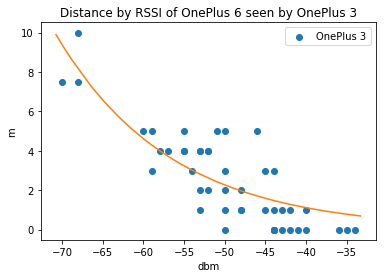

In [422]:
#How does the function fit
fit1, params1 = curve_fit(distance_by_rssi,rm1[:,1],rm1[:,0])

arr = np.random.uniform(low = min(rm1[:,1]-1), high=max(rm1[:,1]+1), size=(100,))
arr.sort()
dfit1 = distance_by_rssi(arr,*fit1)



plt.title("Distance by RSSI of " + non_static['name'] + " seen by " + device1['name'])
plt.ylabel('m')
plt.xlabel('dbm')
p1 = plt.scatter(rm1[:,1],rm1[:,0])
p1.set_label(device1['name'])
plt.plot(arr,dfit1,color='C1')
plt.legend()
plt.legend(loc='best')

dfit1 = distance_by_rssi(rm1[:,1],*fit1)

# rmfit1 = []
# dtfit1_distances = pd.DataFrame({'distance' : dfit1, 'rssi' : np1[:,1]})
# for distance in distances:
#     l1 = dtfit1_distances[np.floor(dtfit1_distances['distance']) == distance].values.tolist()
#     if len(l1) > 0 :
#         eps1 = dt1_st[dt1_st.distance ==distance]['std'].values
#         eps1 = eps1 if eps1 != None else 1
#         clustering1 = DBSCAN(eps=eps1, min_samples=1).fit(l1)
#         l1 = np.array(l1)
#         print(clustering1.labels_)
#         for i,result in enumerate(clustering1.labels_):
#             if result == 0:
#                 rmfit1.append([distance,l1[i,1]])
# rmfit1 = np.array(rmfit1)

# plt.scatter(rmfit1[:,1],rmfit1[:,0])





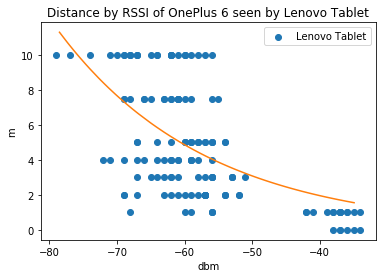

In [423]:
#How does the function fit
fit2, params2 = curve_fit(distance_by_rssi,rm2[:,1],rm2[:,0])
arr = np.random.uniform(low = min(rm2[:,1]), high=max(rm2[:,1]), size=(100,))
arr.sort()
dfit2 = distance_by_rssi(arr,*fit2)
fig = plt.plot()
plt.title("Distance by RSSI of " + non_static['name'] + " seen by " + device2['name'])
plt.ylabel('m')
plt.xlabel('dbm')
p1 = plt.scatter(rm2[:,1],rm2[:,0])
p1.set_label(device2['name'])
plt.plot(arr,dfit2,color='C1')
plt.legend()
plt.legend(loc='best')
plt.show()
dfit2 = distance_by_rssi(rm2[:,1],*fit2)

In [1]:
#Rssi by distance
#Curve fit
#fit, params = curve_fit(rssi_by_distance,rm1[:,1],rm1[:,0])

plt.title("RSSI by distance")
plt.xlabel('m')
plt.ylabel('dbm')

#p1 = plt.scatter(list1_dist[:,0],list1_dist[:,1])
p1 = plt.scatter(rm1[:,0],rm1[:,1])
p1.set_label(device1['name'])
p3 = plt.boxplot(bx_1,positions = distances,vert=False)


plt.legend()
plt.legend(loc='best')
plt.show()

NameError: name 'plt' is not defined

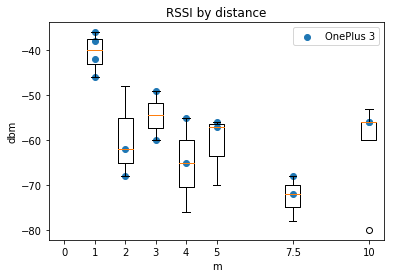

In [404]:
#Rssi by distance
fig = plt.plot()
plt.title("RSSI by distance")
plt.xlabel('m')
plt.ylabel('dbm')
#p2 = plt.scatter(list2_dist[:,0],list2_dist[:,1])
p2 = plt.scatter(rm2[:,0],rm2[:,1])
p2.set_label(device1['name'])

p3 = plt.boxplot(np.array([device]),positions = distances)
plt.legend()
plt.legend(loc='best')
plt.show()

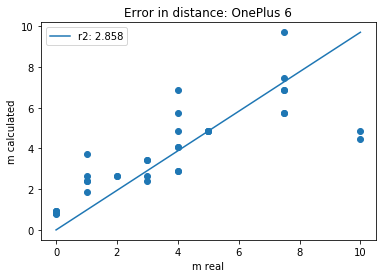

In [405]:
#Optimize distance vs distance(
dig_line = np.array([[0,0],[max(rm1[:,0]),max(dfit1)]])
err = mean_squared_error(rm1[:,0],dfit1)
fig = plt.plot()
plt.title("Error in distance: " + device1['name'])
plt.ylabel('m calculated')
plt.xlabel('m real')

p1 = plt.scatter(rm1[:,0],dfit1)
p2 = plt.plot(dig_line[:,0],dig_line[:,1], label='r2: '+str(round(err,3)))
plt.legend(loc='best')
plt.show()

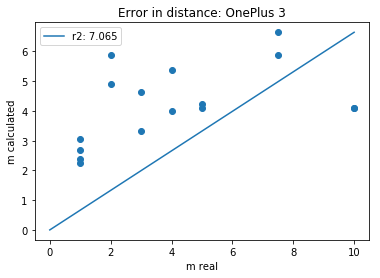

In [406]:
#Optimize distance vs distance(
dig_line = np.array([[0,0],[max(rm2[:,0]),max(dfit2)]])

fig = plt.plot()
plt.title("Error in distance: " + device2['name'])
plt.ylabel('m calculated')
plt.xlabel('m real')
p1 = plt.scatter(rm2[:,0],dfit2)


err = mean_squared_error(rm2[:,0],dfit2)
p2 = plt.plot(dig_line[:,0],dig_line[:,1], label='r2: '+str(round(err,3)))
plt.legend(loc='best')
plt.show()



[-40.449998     2.88493467]


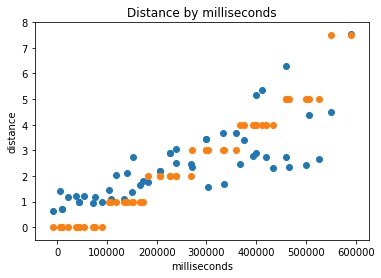

In [345]:
##Test model with (rssi --> distance by time)
dfit1 = distance_by_rssi(np1[:,1],*fit1)

print(fit1)
fig = plt.plot()
plt.title("Distance by milliseconds")
plt.xlabel("milliseconds")
plt.ylabel("distance")
p1 = plt.scatter(np1[:,0],dfit1)
p2 = plt.scatter(list1_dist[:,2],list1_dist[:,0],color='C1')
plt.show()



[-33.95823729   3.79937947]


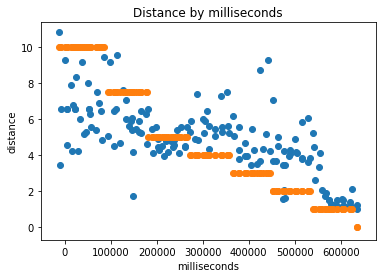

In [346]:
##Test model with (rssi --> distance by time)
dfit2 = distance_by_rssi(np2[:,1],*fit2)


print(fit2)
fig = plt.plot()
plt.title("Distance by milliseconds")
plt.xlabel("milliseconds")
plt.ylabel("distance")
p1 = plt.scatter(np2[:,0],dfit2)
p2 = plt.scatter(list2_dist[:,2],list2_dist[:,0],color="C1")
plt.show()


In [347]:
print(fit1)
print(fit2)

[-40.449998     2.88493467]
[-33.95823729   3.79937947]
